# Definição do problema

Com dados colhidos sobre restaurantes brasileiros incluídos no Ifood, visamos investigar a existência de padrões nos dados que expliquem o rating (as nota providas pelos usuários) de cada restaurante. Ao longo do notebook, analisaremos variáveis que possam estar relacioanadas ao nosso objetivo, e também iremos tentar construir modelos de Machine Learning que possam tentar prever se um restaurante será bem avaliado ou não, baseado soemente em suas características na plataforma. 

# Descrição do conjunto de dados

A base de dados utilizada para esse trabalho foi obtida no *Kaggle* e trata-se de uma lista com todos os restaurantes presentes no ifood-brasil nas datas de 27 de fevereiro de 2021 e 11 de novembro de 2020. Nela estão presentes os seguintes dados para cada restaurante: nome, logo, categoria, taxa de entrega, localização, faixa de preço, nota, consumação mínima, tags, código de pagamento e URL.

Pode-se ter acesso a ela pelo seguinte link: https://www.kaggle.com/datasets/ricardotachinardi/ifood-restaurants-data

# Metodologia

## Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import cv2 
from tqdm import tqdm
import pickle
import urllib.request
import requests
from PIL import ImageFile
from tensorflow.keras.models import load_model

2023-01-31 09:04:09.069497: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-31 09:04:09.348527: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-31 09:04:09.393290: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-31 09:04:09.393313: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Importando Base de Dados

In [2]:
feData = pd.read_csv('data/ifood-restaurants-february-2021.csv')
noData = pd.read_csv('data/ifood-restaurants-november-2020.csv')

Visualização parcial dos dados: 

In [3]:
feData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406399 entries, 0 to 406398
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   availableForScheduling  406399 non-null  bool   
 1   avatar                  406122 non-null  object 
 2   category                406399 non-null  object 
 3   delivery_fee            406399 non-null  float64
 4   delivery_time           406399 non-null  int64  
 5   distance                406399 non-null  float64
 6   ibge                    406399 non-null  int64  
 7   minimumOrderValue       406399 non-null  float64
 8   name                    406399 non-null  object 
 9   paymentCodes            406397 non-null  object 
 10  price_range             406399 non-null  object 
 11  rating                  406399 non-null  float64
 12  tags                    406399 non-null  object 
 13  url                     406399 non-null  object 
dtypes: bool(1), float64(

## Limpando e Analisando os Dados

Iremos selecionar apenas os restaurantes que sobreviveram de novembro de 2020 até feveiro de 2021:

In [4]:
data = feData[feData['url'].isin(noData['url'])]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317191 entries, 0 to 406398
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   availableForScheduling  317191 non-null  bool   
 1   avatar                  316929 non-null  object 
 2   category                317191 non-null  object 
 3   delivery_fee            317191 non-null  float64
 4   delivery_time           317191 non-null  int64  
 5   distance                317191 non-null  float64
 6   ibge                    317191 non-null  int64  
 7   minimumOrderValue       317191 non-null  float64
 8   name                    317191 non-null  object 
 9   paymentCodes            317191 non-null  object 
 10  price_range             317191 non-null  object 
 11  rating                  317191 non-null  float64
 12  tags                    317191 non-null  object 
 13  url                     317191 non-null  object 
dtypes: bool(1), float64(

Visualização das notas dos restaurantes selecionados:

<AxesSubplot: ylabel='Frequency'>

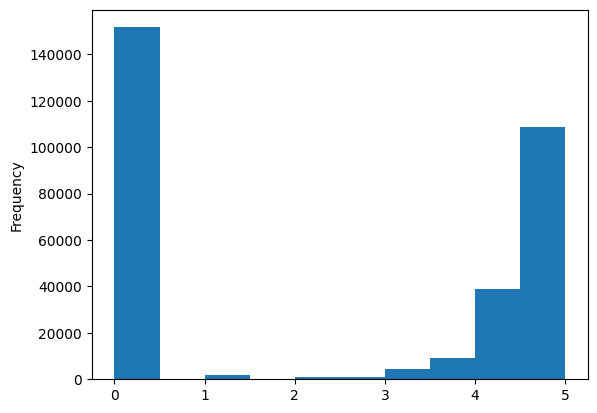

In [5]:
data['rating'].plot.hist(bins=10)

Iremos remover os restaurantes com avaliações iguais a **0** ou **5** para limpar os dados. Tais casos enquadram-se em restaurantes com nenhuma avaliação (nota 0), ou restaurantes com pouquíssimas avaliações (nota 5) que podem prejudicar a nossa análise.

In [6]:
data = data[(data['rating'] != 0)&(data['rating'] != 5)]
data = data.reset_index(drop=True)

Nova distribuição de Notas após a redução:

<AxesSubplot: ylabel='Frequency'>

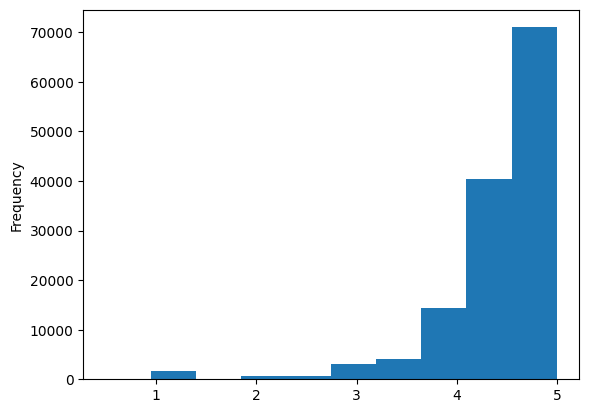

In [7]:
data['rating'].plot.hist(bins=10)

<AxesSubplot: >

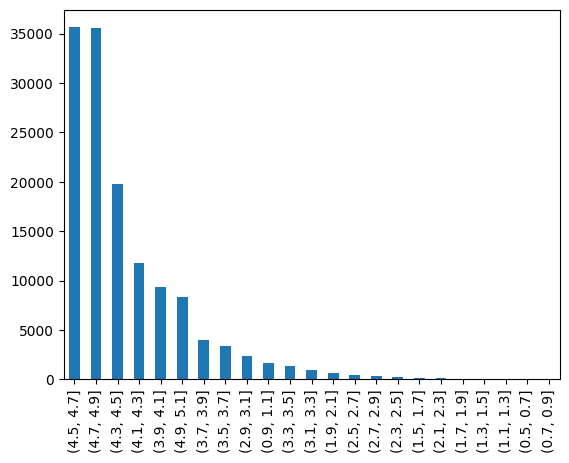

In [8]:
data['rating_bin'] = pd.cut(data['rating'], np.arange(0.5, 5.2, 0.2))
data['rating_bin'].value_counts().plot.bar()

Analisando o gráfico, podemos ver que as notas se aproximam, no geral, bastante de 5. Por isso, para que possamos analisar as características dos restaurantes mais bem avaliados, podemos divdir o dataset em dois grupos: 

- O grupo elite, com as maiores notas, deve conter os restaurantes com nota maior ou igual a 4,5. 

- O grupo não-elite, com as menores notas, deve conter os restaurantes com nota menor que 4,5.

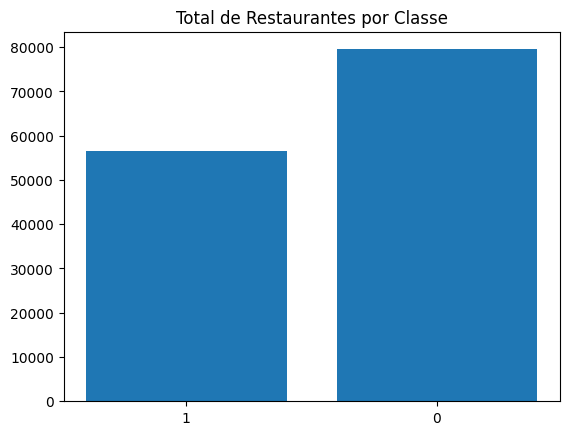

In [11]:
data['rating_max'] = data['rating'].apply(lambda x: 1 if x >= 4.5 else 0)

class_counts = data['rating_max'].value_counts()

plt.bar(class_counts.index, class_counts.values)

plt.xticks(class_counts.index, ['0', '1'])
plt.title('Total de Restaurantes por Classe')
plt.show()

In [13]:
elite = data[data['rating_max'] == 1]
not_elite = data[data['rating_max'] == 0]

Visualização da presença de restaurantes da elite e da não-elite nas diferentes modalidades de custo:

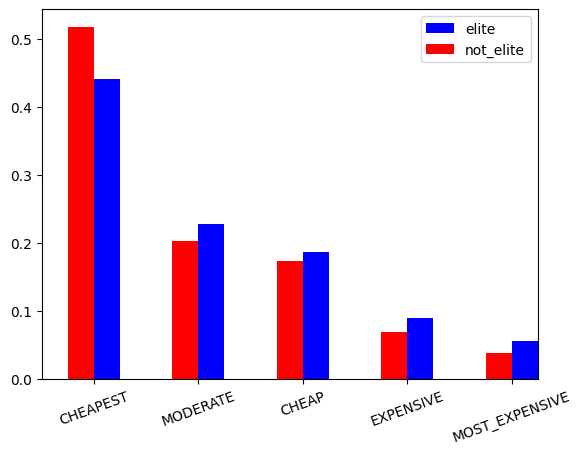

In [14]:
fig, ax = plt.subplots()
(elite['price_range'].value_counts()/elite['price_range'].count()).plot.bar(ax=ax, color='blue', position=0, width=0.25, label='elite')
(not_elite['price_range'].value_counts()/not_elite['price_range'].count()).plot.bar(ax=ax, color='red', position=1, width=0.25, label='not_elite')
plt.xticks(rotation=20)
plt.legend()
plt.show()

Visualização da presença de restaurantes da elite e da não-elite nas diferentes categorias:

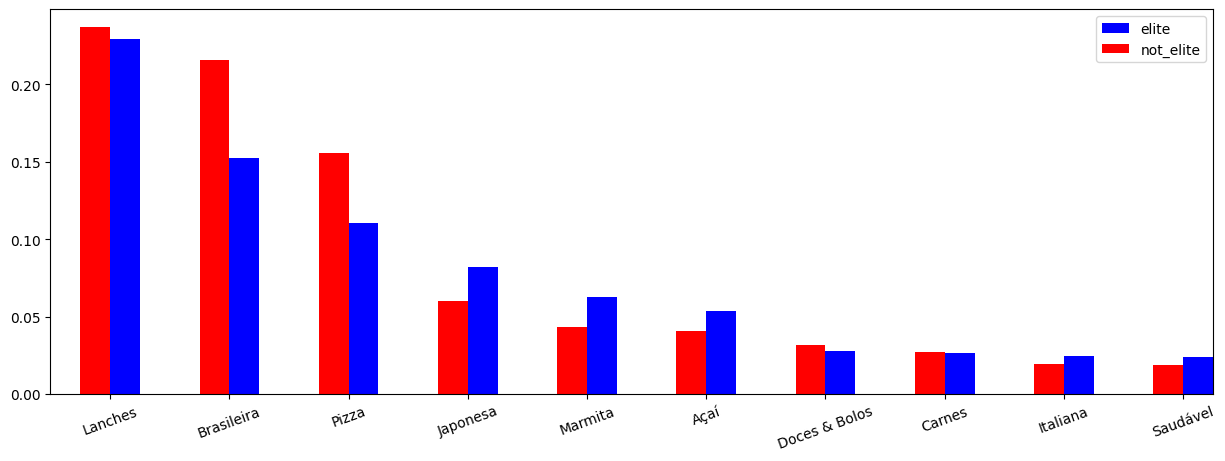

In [12]:
fig, ax = plt.subplots(figsize=(15,5))
(elite['category'].value_counts()[elite['category'].value_counts() > 1000]/elite['category'].count()).plot.bar(ax=ax, color='blue', position=0, width=0.25, label='elite')
(not_elite['category'].value_counts()[not_elite['category'].value_counts() > 1000]/not_elite['category'].count()).plot.bar(ax=ax, color='red', position=1, width=0.25, label='not_elite')
plt.xticks(rotation=20)

plt.legend()
plt.show()

In [13]:
print('Tabelando valores médios para as modalidades Elite e Não_Elite:')
print('Tempo de entrega:')
print("Elite - {0:.3f}".format(elite['delivery_time'].mean()))
print("Não Elite - {0:.3f}\n".format(not_elite['delivery_time'].mean()))
print('Taxa de entrega:')
print("Elite - {0:.3f}".format(elite['delivery_fee'].mean()))
print("Não Elite - {0:.3f}\n".format(not_elite['delivery_fee'].mean()))
print('Consumassão mínima:')
print("Elite - {0:.3f}".format(elite['minimumOrderValue'].mean()))
print("Não Elite - {0:.3f}\n".format(not_elite['minimumOrderValue'].mean()))

Tabelando valores médios para as modalidades Elite e Não_Elite:
Tempo de entrega:
Elite - 44.049
Não Elite - 48.441

Taxa de entrega:
Elite - 7.044
Não Elite - 6.463

Consumassão mínima:
Elite - 15.734
Não Elite - 17.434



## Construindo Modelos de Classificação

A partir de agora, nosso objetivo é construir um modelo classificador capaz de identificar padrões que possam determinar se um restaurante faz ou não parte da Elite. Com esse objetivo em mente, decidimos por construir uma Rede Neural Global capaz de conciliar duas outras Redes específicas.

Uma delas será treinada com os dados numéricos presentes no DataFrame que, como pudemos visualizar, apresentam um leve sinal que distingue as classes de restaurantes.

Para a outra Rede seguimos a heurística de que as logos dos restaurantes talvez pudessem influenciar suas respectivas notas, então, a partir dessa ideia, aplicamos um modelo neural convolucional para verificar se esse padrão de fato acontece.

### Coletando as Logos dos Restaurantes Selecionados

In [ ]:
# avatares = data['avatar']
# if not os.path.exists('data/images'):
#     os.makedirs('data/images')

# for i in tqdm(range(0, len(avatares))):
#     url = avatares.values[i]
#     try: 
#         response = requests.get(url)
#     except:
#         continue

#     if response.status_code:
#         try:
#             fp = open(f'data/images/{str(i)}.jpg', 'wb')
#             fp.write(response.content)
#             fp.close()

#             image = Image.open(f'data/images/{str(i)}.jpg')
#             image.thumbnail((64,64))
#             image.save(f'data/images/{str(i)}.jpg')
#         except:
#             continue
#     else:
#         continue

As imagens são armazenadas no tamanhho 64x64 para otimizar espaço e também diminuir a necessidade computacional. Estamos interessados nas cores e formatos maiores, logo os detalhes que se omitem pela nova escala não são muito relevantes.

#### Organizando as Imagens em diretórios de treino e test, elite e não-elite

In [ ]:
# import os
# import shutil
# import random

# creating folders
# if not os.path.exists('train'):
#     os.makedirs('train')
# if not os.path.exists(('train/0')): 
#     os.makedirs('train/0')
# if not os.path.exists(('train/1')):
#     os.makedirs('train/1')
# if not os.path.exists('test'):
#     os.makedirs('test')
# if not os.path.exists(('test/0')):
#     os.makedirs('test/0')
# if not os.path.exists(('test/1')):
#     os.makedirs('test/1')


# for i in tqdm(data.index): 
#     if not os.path.isfile('images/'+'{}.jpg'.format(i)):
#         continue
#     if data['isElite'].values[i] == 1:
#         if random.random() < 0.75:
#             shutil.copy('images/'+ '{}.jpg'.format(i), 'train/1/'+'{}.jpg'.format(i))
#         else:
#             shutil.copy('images/'+ '{}.jpg'.format(i), 'test/1/'+'{}.jpg'.format(i))
#     else:
#         if random.random() < 0.75: 
#             shutil.copy('images/'+ '{}.jpg'.format(i), 'train/0/'+'{}.jpg'.format(i))
#         else:
#             shutil.copy('images/'+ '{}.jpg'.format(i), 'test/0/'+'{}.jpg'.format(i))

### Reconstruindo DataFrame

A princípio, precisamos reconstruir o DataFrame para valores computáveis que se encaixam no classificador. Iremos retirar as colunas que não são aplicáveis e expandir *category* e *price_range* para múltiplas colunas com valores **0** ou **1**

In [16]:
data_ml = pd.get_dummies(data, columns=['category','price_range'], prefix = ['category','price_range'])
data_ml['availableForScheduling'] = data['availableForScheduling'].apply(lambda x: 0 if x == 'False' else 1)
data_ml['isElite'] = data['rating'].apply(lambda x: 1 if x >= 4.5 else 0)
data_ml = data_ml.drop(['distance','ibge','name','paymentCodes','tags','url','rating','rating_max','rating_bin','avatar'], axis=1)

scaler = StandardScaler()
data_ml[['delivery_time','delivery_fee','minimumOrderValue']] = scaler.fit_transform(data_ml[['delivery_time','delivery_fee','minimumOrderValue']])

In [15]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136148 entries, 0 to 136147
Data columns (total 70 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   availableForScheduling      136148 non-null  int64  
 1   delivery_fee                136148 non-null  float64
 2   delivery_time               136148 non-null  float64
 3   minimumOrderValue           136148 non-null  float64
 4   category_Africana           136148 non-null  uint8  
 5   category_Alemã              136148 non-null  uint8  
 6   category_Argentina          136148 non-null  uint8  
 7   category_Asiática           136148 non-null  uint8  
 8   category_Açaí               136148 non-null  uint8  
 9   category_Baiana             136148 non-null  uint8  
 10  category_Bebidas            136148 non-null  uint8  
 11  category_Brasileira         136148 non-null  uint8  
 12  category_Cafeteria          136148 non-null  uint8  
 13  category_Carne

Como nossa proposta é também analisar as logos dos restaurantes, temos que filtrar o DataFrame para comportar somente os restaurantes em que as logos puderam ser capturadas.

In [17]:
files = os.listdir('data/images')
files = [int(file.replace('.jpg','')) for file in files]

data_ml = data_ml.loc[files]

### Construindo Classificador Tabular

In [17]:
X = data_ml.drop(['isElite'], axis=1)
y = data_ml['isElite']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Antes de construirmos a Rede Neural, decidimor por testar o XGboost, um modelo de regressão de gradiente descendente popular, para tentar encontrar um padrão nos restaurantes mais bem avaliados.

In [64]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 61.82%


Com a visualização da perfomance do XGboots, partimos para a Rede Neural a fim de tentar capturar padrões mais complexos.

A decisão de aplicar-se **40** epochs baseou-se em teste, visto que quando aumentávamos esse valor, o classificador ia muito bem para os dados de treino, porém performava mal sob os dados de teste.

In [24]:
model_tabular = Sequential()
model_tabular.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model_tabular.add(Dense(32, activation='relu'))
model_tabular.add(Dense(16, activation='relu'))
model_tabular.add(Dense(1, activation='sigmoid'))

model_tabular.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


tabular_history = model_tabular.fit(X_train, y_train, epochs=40)

Epoch 1/40
1668/1668 [==============================] - 2s 718us/step - loss: 0.6531 - accuracy: 0.6046
Epoch 2/40
1668/1668 [==============================] - 1s 687us/step - loss: 0.6466 - accuracy: 0.6131
Epoch 3/40
1668/1668 [==============================] - 1s 660us/step - loss: 0.6448 - accuracy: 0.6156
Epoch 4/40
1668/1668 [==============================] - 1s 672us/step - loss: 0.6437 - accuracy: 0.6168
Epoch 5/40
1668/1668 [==============================] - 1s 656us/step - loss: 0.6429 - accuracy: 0.6171
Epoch 6/40
1668/1668 [==============================] - 1s 641us/step - loss: 0.6422 - accuracy: 0.6181
Epoch 7/40
1668/1668 [==============================] - 1s 640us/step - loss: 0.6412 - accuracy: 0.6193
Epoch 8/40
1668/1668 [==============================] - 1s 646us/step - loss: 0.6407 - accuracy: 0.6204
Epoch 9/40
1668/1668 [==============================] - 1s 652us/step - loss: 0.6397 - accuracy: 0.6203
Epoch 10/40
1668/1668 [==============================] - 1s 660u

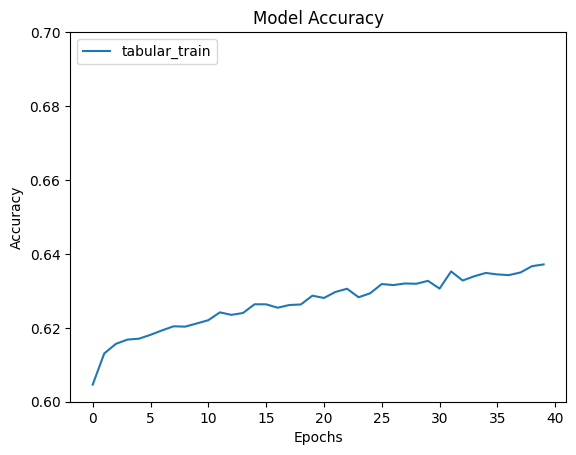

In [25]:
plt.plot(tabular_history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['tabular_train'], loc = 'upper left')
plt.ylim(0.6, 0.7)
plt.show()

In [26]:
test_loss, test_acc = model_tabular.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

417/417 - 0s - loss: 0.6579 - accuracy: 0.6103 - 268ms/epoch - 643us/step

Test accuracy: 0.6102864146232605


Chegamos na conclusão que os dados tabulares, por si só, não indicam um padrão muito forte para a classificação dos restaurantes, uma vez que o aumento da acurácia no treino se dá de forma lenta, não ultrapassando valores de *64%* para **40** epochs, e, quando validamos o modelo sob os dados de teste, o valor cai para *61%*.

### Importando Imagens para treino e test

In [18]:
X_train_tabular = []
X_test_tabular = []
y_train_tabular = []
y_test_tabular = []

X_train_logo = []
y_train_logo = []


for i in os.listdir('data/train'):
    for j in tqdm(os.listdir('data/train/'+i)):
      
        img = cv2.imread('data/train/'+i+'/'+j)
        if img is not None:
            y_train_logo.append(i)
            img = cv2.resize(img, (64,64))
            X_train_logo.append(img)
            X_train_tabular.append(data_ml.loc[int(j.split('.')[0])].drop(['isElite']))
            y_train_tabular.append(data_ml.loc[int(j.split('.')[0])]['isElite'])
    

X_test_logo = []
y_test_logo = []


for i in os.listdir('data/test'):
    for j in tqdm(os.listdir('data/test/'+i)):
        img = cv2.imread('data/test/'+i+'/'+j)
        if img is not None:
            img = cv2.resize(img, (64,64))
            y_test_logo.append(i)
            X_test_logo.append(img)
            X_test_tabular.append(data_ml.loc[int(j.split('.')[0])].drop(['isElite']))
            y_test_tabular.append(data_ml.loc[int(j.split('.')[0])]['isElite'])

100%|██████████| 7030/7030 [00:03<00:00, 2059.86it/s]


In [ ]:
pickle.dump(X_train_logo, open('pkl_files/X_train_logo.pkl','wb'))
pickle.dump(y_train_logo, open('pkl_files/y_train_logo.pkl','wb'))
pickle.dump(X_test_logo, open('pkl_files/X_test_logo.pkl','wb'))
pickle.dump(y_test_logo, open('pkl_files//y_test_logo.pkl','wb'))

pickle.dump(X_train_tabular, open('pkl_files/X_train_tabular.pkl','wb'))
pickle.dump(y_train_tabular, open('pkl_files/y_train_tabular.pkl','wb'))
pickle.dump(X_test_tabular, open('pkl_files/X_test_tabular.pkl','wb'))
pickle.dump(y_test_tabular, open('pkl_files/y_test_tabular.pkl','wb'))

In [19]:
X_train_logo = pickle.load(open('pkl_files/X_train_logo.pkl','rb'))
y_train_logo = pickle.load(open('pkl_files/y_train_logo.pkl','rb'))
X_test_logo = pickle.load(open('pkl_files/X_test_logo.pkl','rb'))
y_test_logo = pickle.load(open('pkl_files/y_test_logo.pkl','rb'))

X_train_tabular = pickle.load(open('pkl_files/X_train_tabular.pkl','rb'))
y_train_tabular = pickle.load(open('pkl_files/y_train_tabular.pkl','rb'))
X_test_tabular = pickle.load(open('pkl_files/X_test_tabular.pkl','rb'))
y_test_tabular = pickle.load(open('pkl_files/y_test_tabular.pkl','rb'))

### Construindo Classificador para as Logos

In [35]:
model_logo = Sequential()

model_logo.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
model_logo.add(MaxPooling2D(pool_size=(2, 2)))
model_logo.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_logo.add(MaxPooling2D(pool_size=(2, 2)))

model_logo.add(Flatten())
model_logo.add(Dense(128, activation='relu'))
model_logo.add(Dense(2, activation='softmax'))

model_logo.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
y_train_logo = np.array(y_train_logo).astype('float32')
y_test_logo = np.array(y_test_logo).astype('float32')

O modelo será treinado em apenas 20 epochs, visto que foi percebido uma tendência muito forte de overfitting para as logos.

In [36]:
logo_history = model_logo.fit(np.array(X_train_logo),y_train_logo,epochs=20)

Epoch 1/20
1549/1549 [==============================] - 33s 21ms/step - loss: 1.3423 - accuracy: 0.5740
Epoch 2/20
1549/1549 [==============================] - 32s 21ms/step - loss: 0.6768 - accuracy: 0.5868
Epoch 3/20
1549/1549 [==============================] - 33s 21ms/step - loss: 0.6757 - accuracy: 0.5881
Epoch 4/20
1549/1549 [==============================] - 32s 21ms/step - loss: 0.6719 - accuracy: 0.5937
Epoch 5/20
1549/1549 [==============================] - 32s 21ms/step - loss: 0.6671 - accuracy: 0.5973
Epoch 6/20
1549/1549 [==============================] - 32s 21ms/step - loss: 0.6590 - accuracy: 0.6047
Epoch 7/20
1549/1549 [==============================] - 32s 21ms/step - loss: 0.6448 - accuracy: 0.6159
Epoch 8/20
1549/1549 [==============================] - 32s 21ms/step - loss: 0.6293 - accuracy: 0.6259
Epoch 9/20
1549/1549 [==============================] - 34s 22ms/step - loss: 0.6156 - accuracy: 0.6366
Epoch 10/20
1549/1549 [==============================] - 32s 21m

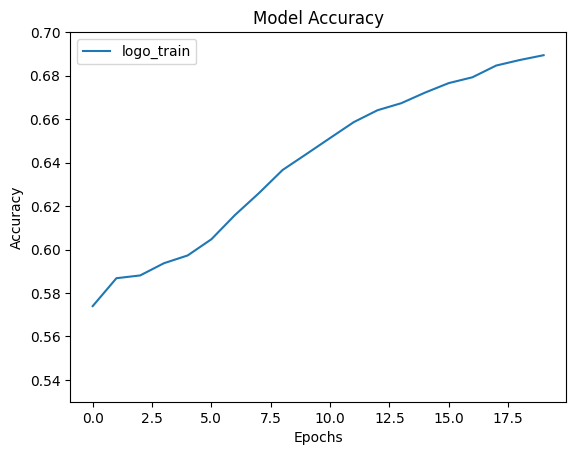

In [37]:
plt.plot(logo_history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim(0.53, 0.7)
plt.legend(['logo_train'], loc = 'upper left')
plt.show()

In [38]:
#validate the model
model_logo.evaluate(np.array(X_test_logo),y_test_logo)

521/521 [==============================] - 3s 6ms/step - loss: 1.2149 - accuracy: 0.5699


[1.214935064315796, 0.5699195861816406]

Ao analisarmos os resultados obtidos percebemos que não foi possível capturar uma correlação entre as logos e notas dos restaurantes, visto que, embora apresenta-se uma acurácia crescente para os dados de treino ao incrementarmos a quantidade de épocas, quando validamos o modelo sob a base de teste, este não apresenta boa performace, com acurácia de apenas *57%*.

### Classificador Global

In [25]:
input_1 = tf.keras.layers.Input(shape=(69,))
input_2 = tf.keras.layers.Input(shape=(64, 64, 3))

output_1 = model_tabular(input_1)
output_2 = model_logo(input_2)

concatenated = tf.keras.layers.concatenate([output_1, output_2])

concatenated = tf.keras.layers.Dense(units=32, activation='relu')(concatenated)

output = tf.keras.layers.Dense(units=2, activation='softmax')(concatenated)

final_model = tf.keras.models.Model(inputs=[input_1, input_2], outputs=[output])

final_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
final_history = final_model.fit([np.array(X_train_tabular), np.array(X_train_logo)], y_train_logo, epochs=25, batch_size=32)

Epoch 1/25
1549/1549 [==============================] - 34s 22ms/step - loss: 0.6425 - accuracy: 0.6207
Epoch 2/25
1549/1549 [==============================] - 32s 21ms/step - loss: 0.6329 - accuracy: 0.6290
Epoch 3/25
1549/1549 [==============================] - 32s 21ms/step - loss: 0.6316 - accuracy: 0.6306
Epoch 4/25
1549/1549 [==============================] - 33s 21ms/step - loss: 0.6296 - accuracy: 0.6316
Epoch 5/25
1549/1549 [==============================] - 31s 20ms/step - loss: 0.6284 - accuracy: 0.6315
Epoch 6/25
1549/1549 [==============================] - 31s 20ms/step - loss: 0.6274 - accuracy: 0.6352
Epoch 7/25
1549/1549 [==============================] - 31s 20ms/step - loss: 0.6264 - accuracy: 0.6343
Epoch 8/25
1549/1549 [==============================] - 31s 20ms/step - loss: 0.6262 - accuracy: 0.6344
Epoch 9/25
1549/1549 [==============================] - 31s 20ms/step - loss: 0.6260 - accuracy: 0.6340
Epoch 10/25
1549/1549 [==============================] - 33s 21m

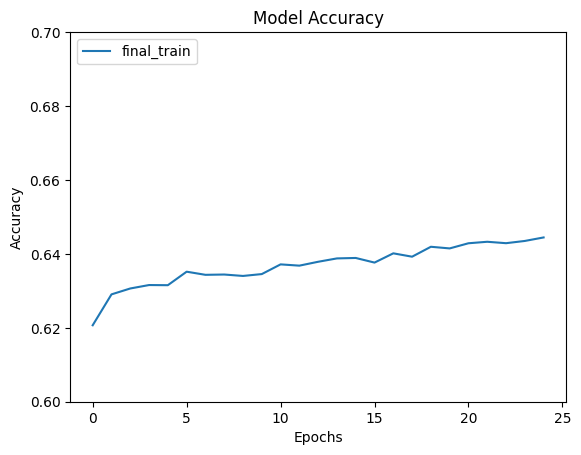

In [27]:
plt.plot(final_history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['final_train'], loc = 'upper left')
plt.ylim(0.6, 0.7)
plt.show()

In [28]:
final_model.evaluate([np.array(X_test_tabular), np.array(X_test_logo)], np.array(y_test_logo))

521/521 [==============================] - 4s 7ms/step - loss: 0.6474 - accuracy: 0.6188


[0.6473679542541504, 0.6187732815742493]

Sobre o classificador global, vemos que ele apresenta uma performance constante sob a base de treino, muito similar ao modelo tabular e, ao validarmo-os sob a base de teste, vemos um resultado praticamente idêntico, aproximadamente *62%*.

# Resultados

## Uma Análise Final do Classificador Global

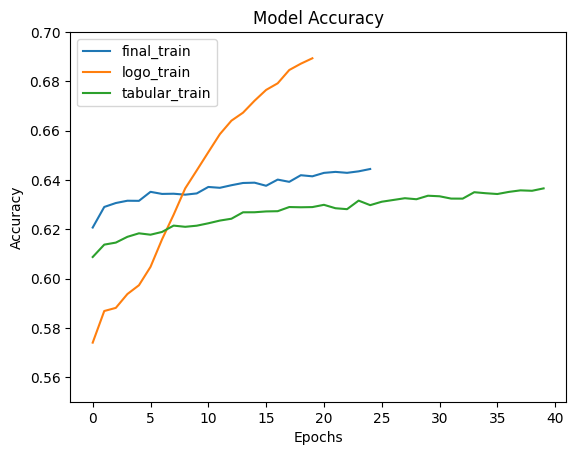

In [39]:
plt.plot(final_history.history['accuracy'], label = 'final_train')
plt.plot(logo_history.history['accuracy'], label = 'logo_train')
plt.plot(tabular_history.history['accuracy'], label = 'tabular_train')
plt.title('Model Accuracy')
plt.legend(loc = 'upper left')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim(0.55, 0.7)
plt.show()

Partimos agora para a análise dos resultados obtidos. Ao todo foram construídas 3 Redes Neurais distintas para a classificação dos restaurantes e nota-se diferentes comportamentos entre elas.

A princípio, baseando-se no gráfico acima, podemos ver que o modelo voltado para as logos destaca-se sob a base de treino. Mesmo com o menor número de epochs, este apresenta forte crescimento de sua acurácia, chegando ao pico de aproximadamente *69%*, o maior valor registrado. Porém, em contraponto, nota-se que esse modelo teve o pior rendimento sob a base de teste, chegando a acurácias de *51%*, ou seja, ele não foi capaz de encontrar uma relação entre logos e notas, sendo apenas capaz a classificar os dados de teste.

Em sequência podemos abordar os modelos tabular e global juntamente já que ambos tiveram resultados similares. Nota-se um maior rendimento para o modelo global, chegando a valores próximos de *64%* de acurácia, enquanto o classificador tabular manteve-se em *62%*, demonstrando que houve uma contribuição das logos para determinar a classe do restaurante. Porém, haja vista a caracteristica do classificador das logos em apenas captar o comportamento do dados sob a base de treino, a contribuição que esse aplicou para o modelo global foi apenas para a acurácia de treino, uma vez que, sob os dados de teste, ambos os classificadores, tabular e global, mantiveram valores próximos de *61%* de acurária.

# Conclusões e Discussões

Após todas as tentativas de construção de um classificador, percebemos que não foi possível captar um sinal forte de relação entre os dados disponibilizados nos perfis dos restaurantes e suas respectivas avalições, visto que todos os nossos modelos construídos mantiveram suas acurácias de teste abaixo de *63%*.

Fomos capazes de destacar alguns possíveis motivos para essa falta de correlação. Dentre eles, a ausência da quantidade de avaliações por restaurante na base de dados é o primeiro a ser percebido, uma vez que, sob um pensamento mais prático, um restaurante que possui uma nota média-alta e com muitas avaliações, apresenta mais mérito e, consequentemente, deveria influenciar mais os modelos do que um restaurante com poucas avaliações e uma nota mais alta, visto que é necessário um esforço maior para se manter um padrão de qualidade sob múltiplas avaliações. A ausência dessa informação pode ter dificultado os nossos classificadores em encontrar um padrão forte nos melhores restaurantes.

Dito isso, chegamos ao final desse projeto com a conclusão de que mais informações são necessárias para a construção de um bom classificador de restaurantes, já que as avaliações sofrem influência não só do que está presente no perfil do restaurante, como também de fatores externos relacionados aos pedidos de cada cliente, informações essas que não estão presentes nessa base de dados. Podemos citar fatores como porcentagem de atrasos por **n** pedidos, tempo de resposta ao cliente e chances de cancelamento como grandes possíveis influenciadores das avaliações dos clientes que, caso possuíssemos tais dados, poderíamos melhorar nossos modelos de forma geral.